In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB

dingen die we moeten bespreken en afstemmen
* de accuracy hangt heel erg af van waar we hem splitten we gebruiken nu een seed dus random_state = 42 is gebruikt in voorbeeld op skippy site maar kan elk nummer zijn -> gebruik k fold of bootstrap
* kijken of ik juiste data gebruik nu moeten zorgen dat 1 uiteindelijke data is en duidelijk welke dat is
* use topdown of top up attribute removing of het accuracy verbeterd 
* ik gebruik gaussian voor naive bayes en gebruik dan voor gender 0,1,2 is maar naive bayes van gaussian verwacht numerical continuous values dus weet niet of dit mag dan en ergens op slaat
* uren slaap converten misschien zeggen dat ze bijvoorbeeld om 7 wakker moeten wordne en dan hoe veel slaap ze hebben geahd

In [12]:
def import_raw_data():
    """
    Imports data from the ODI-2025.csv file without modifying it, aside from column names.

    :return: The contents of ODI-2025.csv as a pandas dataframe.
    """
    usecols = ['Timestamp',
               'What programme are you in?',
               'Have you taken a course on machine learning?',
               'Have you taken a course on information retrieval?',
               'Have you taken a course on statistics?',
               'Have you taken a course on databases?',
               'What is your gender?',
               'I have used ChatGPT to help me with some of my study assignments ',
               'When is your birthday (date)?',
               'How many students do you estimate there are in the room?',
               'What is your stress level (0-100)?',
               'How many hours per week do you do sports (in whole hours)? ',
               'Give a random number',
               'Time you went to bed Yesterday',
               'What makes a good day for you (1)?',
               'What makes a good day for you (2)?']
    names = ['timestamp',
             'programme',
             'machine_learning',
             'information_retrieval',
             'statistics',
             'databases',
             'gender',
             'chatgpt',
             'birthday',
             'student_estimate',
             'stress',
             'sports',
             'random_number',
             'bedtime',
             'good_day_1',
             'good_day_2']

    df = pd.read_csv('files/ODI-2025.csv', usecols=usecols, sep=';')
    df.columns = names
    return df

def save_dataframe_to_file(df, filename):
    """
    Saves a pandas dataframe to the file DMT_Data.csv with separator ;.

    :param df: Pandas dataframe
    """
    df.to_csv('files/' + filename, index=False, sep=';')

def import_data(filename):
    return pd.read_csv('files/' + filename, sep=';')
    

def import_clean_data():
    return pd.read_csv('files/DMT_Data.csv', sep=';')

df = import_data('DMT_Data_Median.csv')
print(df)

               timestamp                programme machine_learning  \
0    2025-04-01 12:17:00  Artificial Intelligence              yes   
1    2025-04-01 12:17:00  Artificial Intelligence              yes   
2    2025-04-01 12:17:00             Econometrics              yes   
3    2025-04-01 12:17:00             Econometrics              yes   
4    2025-04-01 12:17:00           Bioinformatics              yes   
..                   ...                      ...              ...   
237  2025-04-01 12:20:00  Artificial Intelligence               no   
238  2025-04-01 12:20:00         Computer Science              yes   
239  2025-04-01 12:21:00         Computer Science              yes   
240  2025-04-01 12:21:00         Computer Science              yes   
241  2025-04-01 12:21:00    Computational Science               no   

    information_retrieval statistics databases  gender             chatgpt  \
0                 unknown        yes       yes    male                 yes   
1  

In [13]:
# Stress into three categories
def bin_stress(val):
    if val <= 33:
        return 'Low'
    elif val <= 66:
        return 'Medium'
    else:
        return 'High'
df['stress_class'] = df['stress'].apply(bin_stress)

# Bedtime into hour 
def bedtime_to_hour(t):
    h, m = map(int, t.split(':'))
    return h + (m / 60)
df['bedtime_hour'] = df['bedtime'].apply(bedtime_to_hour)

# Encode master programme
programme_map = {
    'Artificial Intelligence': 0,
    'Computer Science': 1,
    'Computational Science': 2,
    'Econometrics': 3,
    'Finance': 4,
    'Business Analytics': 5,
    'Bioinformatics': 6,
    'Other': 7
}

# Encode into stem or not stem
programme_map1 = {
    'Artificial Intelligence': 0,
    'Computer Science': 0,
    'Computational Science': 0,
    'Econometrics': 1,
    'Finance': 1,
    'Business Analytics': 1,
    'Bioinformatics': 1,
    'Other': 2
}

df['programme_encoded_more'] = df['programme'].map(programme_map1)
df['programme_encoded'] = df['programme'].map(programme_map)
# Amount of sleep if they have to wake up at 7:00 (maakte niet echt verschil)
df['sleep_duration'] = (7 - df['bedtime_hour']) % 24

le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])

In [28]:
# pearson coefficent of linear correlation 
r = np.corrcoef(df['stress'], df['age'])
print('age',r[0,1])
r = np.corrcoef(df['stress'], df['sleep_duration'])
print('sleep duration',r[0,1])
r = np.corrcoef(df['stress'], df['bedtime_hour'])
print('sleep time',r[0,1])
r = np.corrcoef(df['stress'], df['gender_encoded'])
print('gender',r[0,1])
r = np.corrcoef(df['stress'], df['sports'])
print('sports',r[0,1])
r = np.corrcoef(df['stress'], df['programme_encoded'])
print('programme',r[0,1])

age 0.015839165943071384
sleep duration -0.017345238390683592
sleep time 0.012259210348555405
gender -0.02932746924051637
sports -0.26891832984331104
programme 0.043297912416594954


# Decision tree stress 
d is used to for the depth of the tree (hoeveel afsplitsingen), i is used for k fold how many different test and training data. random forest can also be used 

In [ ]:
X = df[['gender_encoded','sports', 'sleep_duration','programme_encoded_more']]
y = df['stress_class']

average_acc = []
def k_fold():
    for d in range(1,30):
        scores = []
        for i in range(100):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
            clf = RandomForestClassifier(max_depth=d, n_estimators=50, random_state=i)
            clf = clf.fit(X_train, y_train)
            #clf = tree.DecisionTreeClassifier(max_depth = d)
            #clf = clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        avg_score = sum(scores) / len(scores)
        average_acc.append(avg_score)
    return average_acc
accuracies = k_fold()
print(accuracies)
plt.plot(range(1, 30), accuracies, marker='o')
plt.title("Average accuracy vs. max_depth")
plt.xlabel("Max Depth")
plt.ylabel("Average accuracy")
plt.show()

# Naive bayes 
hier kan nog gekeken worden naar andere naive bayes nu is gaussian februikt en dit is niet helemaal correct voor gender etc je hebt ook categorial maar dan moeten we sport in weinig/middel/veel enzo en dat leek te verslechteren

In [16]:
#,'bedtime_hour','gender_encoded','programme_encoded''sports',,'programme_encoded'

features = ['gender_encoded','sports','sleep_duration']
target = 'stress_class'

average_accuracy = []
for i in range(200):
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    average_accuracy.append(acc)
mean_accuracy = np.mean(average_accuracy)  
print(mean_accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

0.4370408163265306
Confusion Matrix:
 [[ 3  3  5]
 [ 1 15  4]
 [ 2  8  8]]


# Master programme prediction

In [17]:
le = LabelEncoder()
df['ml_encoded'] = le.fit_transform(df['machine_learning'])
le = LabelEncoder()
df['ir_encoded'] = le.fit_transform(df['information_retrieval'])
le = LabelEncoder()
df['statistics_encoded'] = le.fit_transform(df['statistics'])

In [18]:
r = np.corrcoef(df['programme_encoded'], df['ml_encoded'])
print('machine learning',r[0,1])
r = np.corrcoef(df['programme_encoded'], df['ir_encoded'])
print('information retrieval',r[0,1])
r = np.corrcoef(df['programme_encoded'], df['statistics_encoded'])
print('statistics', r[0,1])

machine learning 0.10716925637018444
information retrieval -0.10922476274286691
statistics -0.019126591974070243


Now all the data is ready to use in the decision tree algortihm first split into training data and test data with 20% test data the rest training data. 

check for best depth so how many splits it will make and look at highest accuracy to determine, we see the accuracy increases with increasing depth but reaches a plateau at about depth = 14 so we use that one in further analysis and in the tree

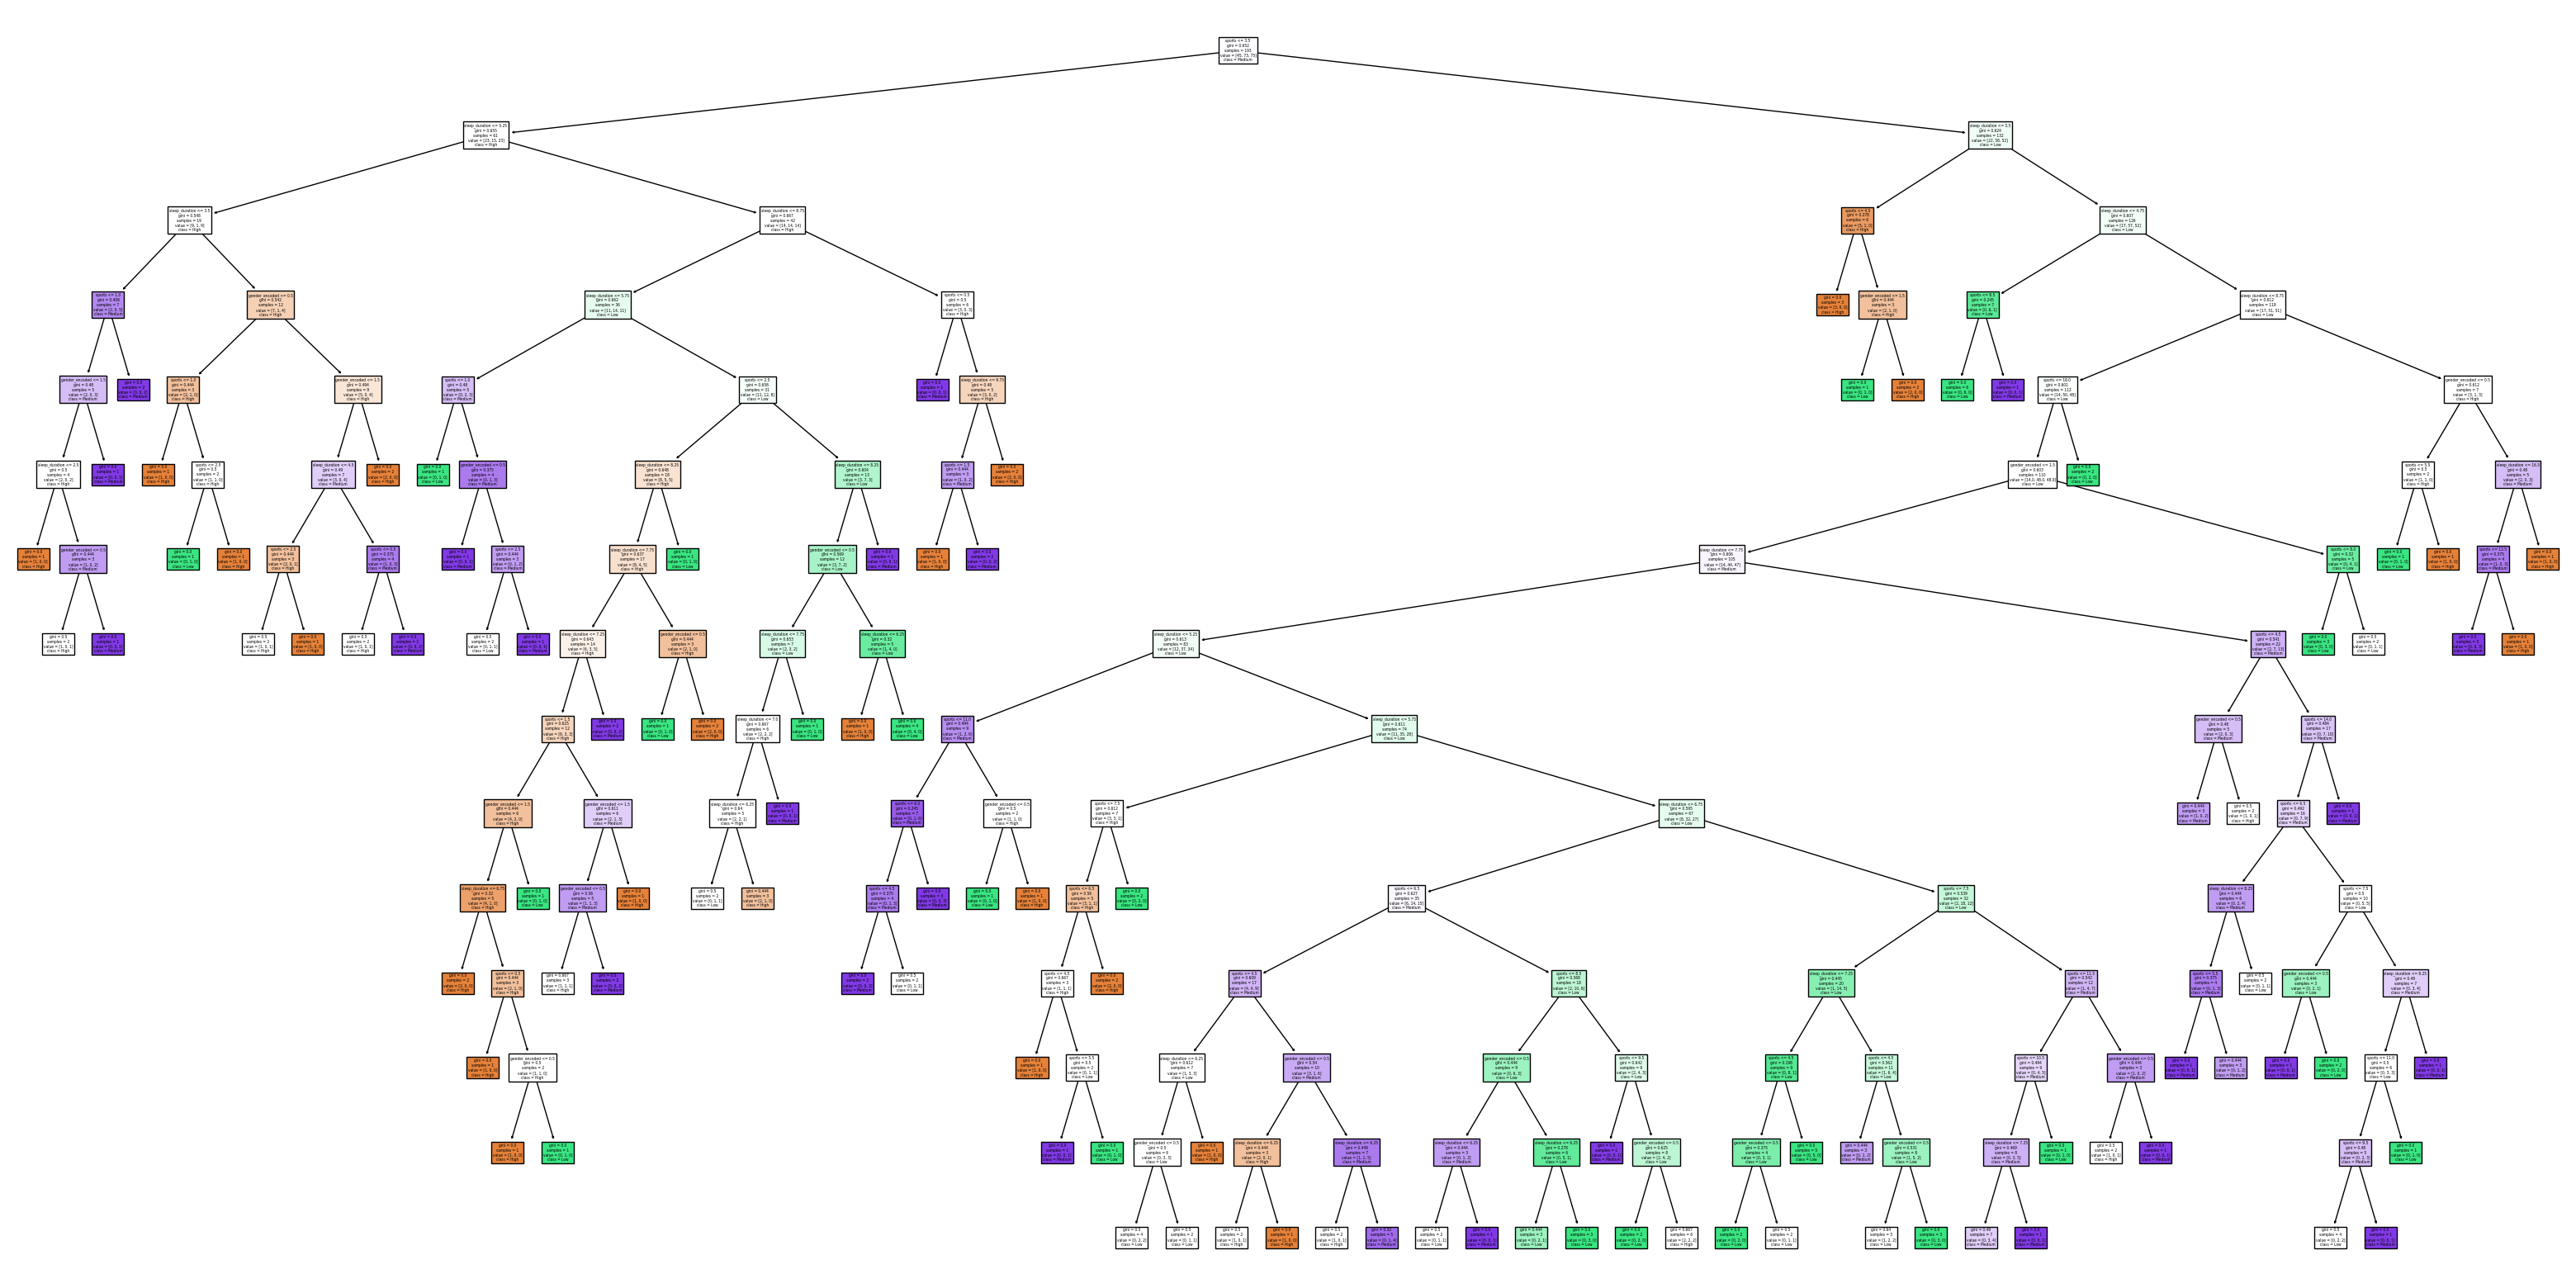

Accuracy:
0.40816326530612246


In [19]:
# random voorbeeld van tree
clf = tree.DecisionTreeClassifier(max_depth = 14)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(40, 20)) 
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_)
plt.savefig("figures/decision_tree_onlyage.png", dpi=300)
plt.show()

y_pred = clf.predict(X_test)
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

An accuracy of 40% is achieved where about half of the test data is correctly predicted this is not high enough. to try to improve this we tried to add the gender also in there but this decreased the accuracy, when the stress level was introduced in a way where 1/3 of quantile of most answers was used this was also not improving the accuracy. maybe bed time improving by 3 classes early bedtime (18-22:30), middle bedtime(23-1), late bedtime (1-6)

In [24]:
features_ = ['ml_encoded','ir_encoded','statistics_encoded']
target_ = 'programme_encoded_more' # more is stem based 

average_accuracy = []
for i in range(200):
    X = df[features_]
    y = df[target_]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    #gnb = GaussianNB()
    #gnb.fit(X_train, y_train)
    model = CategoricalNB()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    average_accuracy.append(acc)
mean_accuracy = np.mean(average_accuracy)  
print(mean_accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

0.6466326530612244
Confusion Matrix:
 [[28  1  0]
 [16  0  0]
 [ 4  0  0]]


In [25]:
print(df['programme_encoded_more'].value_counts(normalize=True))

programme_encoded_more
0    0.665289
1    0.285124
2    0.049587
Name: proportion, dtype: float64
